In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm.notebook import tqdm
import re
plt.style.use('ggplot')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/all-data.csv', names=['Label', 'Text'], encoding='latin-1')
df

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


Text(0.5, 1.0, 'The number of data')

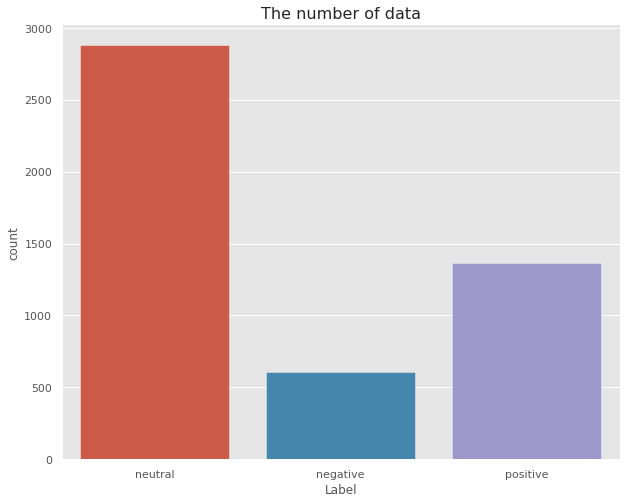

In [ ]:
plt.figure(figsize=(10,8))

sns.countplot(x='Label', data=df)
plt.title('The number of data', fontsize=16)

In [ ]:

sentiment_df = pd.DataFrame(pd.read_excel("/content/drive/MyDrive/LoughranMcDonald_SentimentWordLists_2018.xlsx"))

sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
negative,2355
positive,354


In [ ]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

In [ ]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [ ]:
print(df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(df['Text'], total=df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([df, tone_lmdict_df.reindex(df.index)], axis=1)
train_tone_df

(4846, 2)


,Label,Text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,neutral,"According to Gran , the company has no plans t...",0.000000,22,0,0,[],[]
1,neutral,Technopolis plans to develop in stages an area...,0.000000,28,0,0,[],[]
2,negative,The international electronic industry company ...,-6.060606,33,0,2,[],"[contrary, layoffs]"
3,positive,With the new production plant the company woul...,6.250000,32,2,0,"[improve, profitability]",[]
4,positive,According to the company 's updated strategy f...,0.000000,31,0,0,[],[]
...,...,...,...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,-4.347826,23,1,2,[rebound],"[failed, weakness]"
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0.000000,23,0,0,[],[]
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,5.882353,17,1,0,[gain],[]
4844,negative,Net sales of the Paper segment decreased to EU...,0.000000,37,0,0,[],[]
